<a href="https://colab.research.google.com/github/Adityabaan/PROPHET-IIT_GUWAHATI-Stock-Predictor/blob/main/Prophet_IIT_Guwahati_Adityabaan_Tripathy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install** **Dependencies**

In [ ]:
# Run this cell first in Colab
!pip install yfinance --upgrade --quiet
!pip install prophet --quiet
!pip install statsmodels --quiet
!pip install seaborn --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.9/117.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 50.5 MB/s eta 0:00:00


# **Import All Required Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')
#Official Work of Adityabaan Tripathy

# **Download Data (Batch Download, Rate Limit Safe)**

In [ ]:
# Define your stock universe (feel free to change!)
stocks = [
    'RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'ICICIBANK.NS',
    'HINDUNILVR.NS', 'SBIN.NS', 'AXISBANK.NS', 'BAJFINANCE.NS', 'ASIANPAINT.NS'
]
start_date = '2020-01-01'
end_date = '2024-12-31'

# Batch download data for all stocks
data = yf.download(stocks, start=start_date, end=end_date, group_by='ticker', auto_adjust=True, progress=True)

# Organize data into a dictionary per stock
stock_data = {}
for stock in stocks:
    if stock in data.columns.levels[0]:
        stock_data[stock] = data[stock].dropna().copy()
        stock_data[stock].index = pd.to_datetime(stock_data[stock].index)
    else:
        print(f"Data not found for {stock}")
print(f"Downloaded data for {len(stock_data)} stocks.")

[*********************100%***********************]  10 of 10 completed

Downloaded data for 10 stocks.


# **Data Preprocessing**

In [ ]:
# Preprocess: Handle missing values, add returns
def preprocess(df):
    df = df.copy()
    df = df.fillna(method='ffill').fillna(method='bfill')
    df['Return'] = df['Close'].pct_change()
    return df.dropna()

for stock in stock_data:
    stock_data[stock] = preprocess(stock_data[stock])


# **Train-Test Split (Last 6 Months for Test)**

In [ ]:
test_start_date = (pd.to_datetime(end_date) - pd.DateOffset(months=6)).strftime('%Y-%m-%d')
train_data = {}
test_data = {}

for stock in stock_data:
    train_data[stock] = stock_data[stock][stock_data[stock].index < test_start_date]
    test_data[stock] = stock_data[stock][stock_data[stock].index >= test_start_date]
    print(f"{stock}: Train {len(train_data[stock])}, Test {len(test_data[stock])}")


RELIANCE.NS: Train 1111, Test 125
TCS.NS: Train 1111, Test 125
HDFCBANK.NS: Train 1111, Test 125
INFY.NS: Train 1111, Test 125
ICICIBANK.NS: Train 1111, Test 125
HINDUNILVR.NS: Train 1111, Test 125
SBIN.NS: Train 1111, Test 125
AXISBANK.NS: Train 1111, Test 125
BAJFINANCE.NS: Train 1111, Test 125
ASIANPAINT.NS: Train 1111, Test 125


# **Stationarity Check**

In [ ]:
def check_stationarity(ts):
    result = adfuller(ts.dropna())
    print(f"ADF Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}")
    return result[1] < 0.05  # True if stationary

# Example: Check for one stock
sample_stock = list(stock_data.keys())[0]
print(f"Checking stationarity for {sample_stock}:")
check_stationarity(stock_data[sample_stock]['Close'])


Checking stationarity for RELIANCE.NS:
ADF Statistic: -1.9183, p-value: 0.3235


np.False_

# **ARIMA Forecast**

In [ ]:
# Fit ARIMA on returns for the last 6 months, forecast next 2 days
arima_forecasts = {}
for stock in stock_data:
    ts = test_data[stock]['Return'].dropna()
    try:
        model = ARIMA(ts, order=(1,0,1))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=2)
        last_price = test_data[stock]['Close'].iloc[-1]
        price_forecast = [last_price * (1 + forecast.iloc[0]), last_price * (1 + forecast.iloc[0]) * (1 + forecast.iloc[1])]
        arima_forecasts[stock] = price_forecast
        print(f"{stock}: ARIMA price forecast next 2 days: {price_forecast}")
    except Exception as e:

        print(f"{stock}: ARIMA failed: {e}")


RELIANCE.NS: ARIMA price forecast next 2 days: [np.float64(1208.1392643909012), np.float64(1205.7933880429007)]
TCS.NS: ARIMA price forecast next 2 days: [np.float64(4147.565253152741), np.float64(4152.826450209348)]
HDFCBANK.NS: ARIMA price forecast next 2 days: [np.float64(1778.218270654474), np.float64(1779.2228949438086)]
INFY.NS: ARIMA price forecast next 2 days: [np.float64(1909.6825173893649), np.float64(1913.0280864601705)]
ICICIBANK.NS: ARIMA price forecast next 2 days: [np.float64(1294.169218528572), np.float64(1295.8313233928834)]
HINDUNILVR.NS: ARIMA price forecast next 2 days: [np.float64(2342.6433481349777), np.float64(2341.9347925326792)]
SBIN.NS: ARIMA price forecast next 2 days: [np.float64(788.0901791527998), np.float64(787.6193174491135)]
AXISBANK.NS: ARIMA price forecast next 2 days: [np.float64(1069.1553055523498), np.float64(1067.5780776970057)]
BAJFINANCE.NS: ARIMA price forecast next 2 days: [np.float64(6876.836846350947), np.float64(6875.774422760196)]
ASIANPAI

# **Prophet Forecast**

In [ ]:
prophet_forecasts = {}
for stock in stock_data:
    df = stock_data[stock].reset_index()[['Date','Close']].rename(columns={'Date':'ds','Close':'y'})
    try:
        m = Prophet(daily_seasonality=True)
        m.fit(df)
        future = m.make_future_dataframe(periods=2)
        forecast = m.predict(future)
        next2 = forecast.tail(2)['yhat'].values
        prophet_forecasts[stock] = next2
        print(f"{stock}: Prophet price forecast next 2 days: {next2}")
    except Exception as e:
        print(f"{stock}: Prophet failed: {e}")


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_5el415y/5rvpg_2x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_5el415y/uuow3qwb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49093', 'data', 'file=/tmp/tmp_5el415y/5rvpg_2x.json', 'init=/tmp/tmp_5el415y/uuow3qwb.json', 'output', 'file=/tmp/tmp_5el415y/prophet_modelpgh1u977/prophet_model-20250512071435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:14:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_5el415y/2p1mfypx.json


RELIANCE.NS: Prophet price forecast next 2 days: [1374.29906168 1380.03126669]


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_5el415y/z2lel8lt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24948', 'data', 'file=/tmp/tmp_5el415y/2p1mfypx.json', 'init=/tmp/tmp_5el415y/z2lel8lt.json', 'output', 'file=/tmp/tmp_5el415y/prophet_modeln5vcmq6f/prophet_model-20250512071436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:14:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_5el415y/ag1cb7s3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_5el415y/j_k7d32z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.b

TCS.NS: Prophet price forecast next 2 days: [4514.22580487 4529.71012583]


07:14:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_5el415y/wkyxi083.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_5el415y/my9c6rwy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40704', 'data', 'file=/tmp/tmp_5el415y/wkyxi083.json', 'init=/tmp/tmp_5el415y/my9c6rwy.json', 'output', 'file=/tmp/tmp_5el415y/prophet_modelnxgid3ix/prophet_model-20250512071438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


HDFCBANK.NS: Prophet price forecast next 2 days: [1818.91745012 1820.69724521]


07:14:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_5el415y/1lxcnu5z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_5el415y/mo4630ds.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2329', 'data', 'file=/tmp/tmp_5el415y/1lxcnu5z.json', 'init=/tmp/tmp_5el415y/mo4630ds.json', 'output', 'file=/tmp/tmp_5el415y/prophet_modelje69wds5/prophet_model-20250512071439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


INFY.NS: Prophet price forecast next 2 days: [2007.34722254 2012.07409288]


07:14:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_5el415y/8c2z6urb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_5el415y/q_b3lzuq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15217', 'data', 'file=/tmp/tmp_5el415y/8c2z6urb.json', 'init=/tmp/tmp_5el415y/q_b3lzuq.json', 'output', 'file=/tmp/tmp_5el415y/prophet_modeloo10w4jp/prophet_model-20250512071440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


ICICIBANK.NS: Prophet price forecast next 2 days: [1322.68700869 1323.02141344]


07:14:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_5el415y/logz5_tx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_5el415y/sl0blubn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95641', 'data', 'file=/tmp/tmp_5el415y/logz5_tx.json', 'init=/tmp/tmp_5el415y/sl0blubn.json', 'output', 'file=/tmp/tmp_5el415y/prophet_modeln7_8eyhc/prophet_model-20250512071441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


HINDUNILVR.NS: Prophet price forecast next 2 days: [2564.29636783 2570.93382044]


07:14:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_5el415y/eq0ll8kn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_5el415y/03joksmn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15550', 'data', 'file=/tmp/tmp_5el415y/eq0ll8kn.json', 'init=/tmp/tmp_5el415y/03joksmn.json', 'output', 'file=/tmp/tmp_5el415y/prophet_model8b8gtylm/prophet_model-20250512071442.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


SBIN.NS: Prophet price forecast next 2 days: [880.21287786 882.52473221]


07:14:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_5el415y/li8qpqqt.json


AXISBANK.NS: Prophet price forecast next 2 days: [1211.87933575 1215.26161851]


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_5el415y/4ujk7qb2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62754', 'data', 'file=/tmp/tmp_5el415y/li8qpqqt.json', 'init=/tmp/tmp_5el415y/4ujk7qb2.json', 'output', 'file=/tmp/tmp_5el415y/prophet_modelxmkg6yy5/prophet_model-20250512071444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:14:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:14:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_5el415y/342jpu5x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_5el415y/qex4uopx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.b

BAJFINANCE.NS: Prophet price forecast next 2 days: [6976.03453747 6983.58810533]


07:14:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ASIANPAINT.NS: Prophet price forecast next 2 days: [2802.48077587 2810.59262034]


# **Volatility Analysis**

In [ ]:
# Rolling volatility (annualized) for each stock
volatility = {}
for stock in stock_data:
    returns = stock_data[stock]['Return']
    rolling_vol = returns.rolling(window=30).std() * np.sqrt(252)
    volatility[stock] = rolling_vol.iloc[-1]
    print(f"{stock}: Last 30-day annualized volatility: {volatility[stock]:.4f}")


RELIANCE.NS: Last 30-day annualized volatility: 0.2125
TCS.NS: Last 30-day annualized volatility: 0.2289
HDFCBANK.NS: Last 30-day annualized volatility: 0.1651
INFY.NS: Last 30-day annualized volatility: 0.2238
ICICIBANK.NS: Last 30-day annualized volatility: 0.1480
HINDUNILVR.NS: Last 30-day annualized volatility: 0.2063
SBIN.NS: Last 30-day annualized volatility: 0.2491
AXISBANK.NS: Last 30-day annualized volatility: 0.1721
BAJFINANCE.NS: Last 30-day annualized volatility: 0.2105
ASIANPAINT.NS: Last 30-day annualized volatility: 0.1650


# **Portfolio Allocation**

In [ ]:
# Build a list of allocation records instead of using .append()
allocation_records = []

for stock in prophet_forecasts:
    if stock in volatility and len(prophet_forecasts[stock]) == 2:
        last_price = stock_data[stock]['Close'].iloc[-1]
        ret = (prophet_forecasts[stock][1] - last_price) / last_price
        allocation_records.append({
            'Stock': stock,
            'ForecastReturn': ret,
            'Volatility': volatility[stock]
        })

# Create DataFrame from the list of dictionaries
allocation_df = pd.DataFrame(allocation_records)

# Risk-adjusted score
allocation_df['Score'] = allocation_df['ForecastReturn'] / allocation_df['Volatility']
allocation_df = allocation_df.sort_values('Score', ascending=False).head(5)
allocation_df['Weight'] = allocation_df['Score'] / allocation_df['Score'].sum()
allocation_df['Capital'] = allocation_df['Weight'] * 1_000_000
print(allocation_df[['Stock', 'ForecastReturn', 'Volatility', 'Weight', 'Capital']])


           Stock  ForecastReturn  Volatility    Weight        Capital
9  ASIANPAINT.NS        0.228272    0.165025  0.365854  365854.346876
7    AXISBANK.NS        0.135812    0.172106  0.208711  208710.662518
0    RELIANCE.NS        0.139862    0.212485  0.174091  174091.045026
6        SBIN.NS        0.119529    0.249066  0.126930  126929.758008
5  HINDUNILVR.NS        0.097049    0.206312  0.124414  124414.187573


# **Visualize Portfolio**

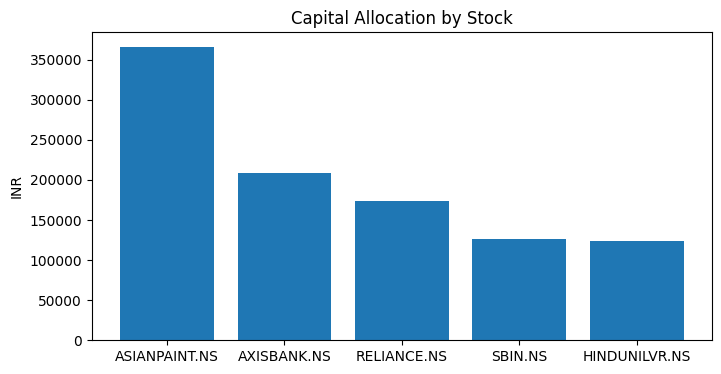

In [ ]:
plt.figure(figsize=(8,4))
plt.bar(allocation_df['Stock'], allocation_df['Capital'])
plt.title('Capital Allocation by Stock')
plt.ylabel('INR')
plt.show()
